In [1]:
import cv2
print(" cv2 version:", cv2.__version__)


 cv2 version: 4.10.0


In [3]:
import os
import numpy as np
import cv2
from glob import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K


In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []

    for filename in sorted(os.listdir(image_dir)):
        if filename.lower().endswith((".jpg", ".png")):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace(".jpg", ".png").replace(".JPG", ".png"))

            # 讀取圖片與遮罩（灰階）
            image = load_img(img_path, target_size=img_size, color_mode="grayscale")
            mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

            images.append(img_to_array(image) / 255.0)
            masks.append((img_to_array(mask) > 127).astype(np.uint8))  # 轉成 0/1 二值

    return np.array(images), np.array(masks)


In [11]:
IMG_SIZE = 256
pixel_per_cm = 72

def load_data(image_dir, mask_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))
    images, masks = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        images.append(img)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        masks.append(np.expand_dims(mask, axis=-1))
    return np.array(images), np.array(masks)

def build_unet(input_shape=(256, 256, 3)):
    def conv_block(x, filters):
        x = Conv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def encoder_block(x, filters):
        s = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(s)
        return s, p

    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        x = Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def calculate_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return intersection / (union + 1e-7)

def get_endpoint_y(mask):
    coords = np.argwhere(mask[..., 0] > 0.5)
    return np.max(coords[:, 0]) if len(coords) > 0 else None

def run_fold(fold_index):
    base_path = f"ETT-v3/Fold{fold_index}"
    x_train, y_train = load_data(os.path.join(base_path, "train"), os.path.join(base_path, "trainannot"))
    x_val, y_val = load_data(os.path.join(base_path, "val"), os.path.join(base_path, "valannot"))
    x_test, y_test = load_data(os.path.join(base_path, "test"), os.path.join(base_path, "testannot"))

    print(f"Fold{fold_index} - Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

    model = build_unet()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(f"unet_fold{fold_index}_best.h5", save_best_only=True)
    ]

    print(f"Fold{fold_index} - Start training...")
    model.fit(x_train, y_train,
              validation_data=(x_val, y_val),
              batch_size=8,
              epochs=30,
              callbacks=callbacks,
              verbose=1)

    print(f"Fold{fold_index} - Start evaluation...")

    ious = []
    errors, acc_05cm, acc_10cm, valid = [], 0, 0, 0
    for i in range(len(x_test)):
        pred = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0]
        pred = (pred > 0.5).astype(np.uint8)

        ious.append(calculate_iou(y_test[i], pred))

        true_y = get_endpoint_y(y_test[i])
        pred_y = get_endpoint_y(pred)
        if true_y is not None and pred_y is not None:
            error_pixel = abs(pred_y - true_y)
            errors.append(error_pixel / pixel_per_cm)
            valid += 1
            if error_pixel <= 36:
                acc_05cm += 1
            if error_pixel <= 72:
                acc_10cm += 1

    print(f"Fold{fold_index} Results:")
    print(f"  Mean IOU: {np.mean(ious):.4f}")
    print(f"  Mean Endpoint Error: {np.mean(errors):.2f} cm")
    print(f"  Accuracy within 0.5 cm: {acc_05cm / valid:.2%}")
    print(f"  Accuracy within 1.0 cm: {acc_10cm / valid:.2%}")

    return {
        "fold": fold_index,
        "mean_iou": np.mean(ious),
        "mean_error_cm": np.mean(errors),
        "acc_05cm": acc_05cm / valid if valid else 0,
        "acc_10cm": acc_10cm / valid if valid else 0
    }


In [12]:
result_fold5 = run_fold(5)


Fold5 - Train: 285, Val: 48, Test: 48
Fold5 - Start training...
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7300 - loss: 0.9613

36/36 ━━━━━━━━━━━━━━━━━━━━ 250s 7s/step - accuracy: 0.7316 - loss: 0.9608 - val_accuracy: 0.9332 - val_loss: 0.9853
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2181s 62s/step - accuracy: 0.9617 - loss: 0.8621 - val_accuracy: 0.9921 - val_loss: 0.9862
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 798s 23s/step - accuracy: 0.9830 - loss: 0.7927 - val_accuracy: 0.9921 - val_loss: 0.9875
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.9891 - loss: 0.7425 - val_accuracy: 0.9920 - val_loss: 0.9887
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 296s 8s/step - accuracy: 0.9912 - loss: 0.7112 - val_accuracy: 0.9921 - val_loss: 0.9878
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2703s 77s/step - accuracy: 0.9923 - loss: 0.6750 - val_accuracy: 0.9921 - val_loss: 0.9869
Fold5 - Start evaluation...
Fold5 Results:
  Mean IOU: 0.0049
  Mean Endpoint Error: 2.55 cm
  Accuracy within 0.5 cm: 0.00%
  Accuracy within 1.0 cm: 0.00%


In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from scipy.ndimage import binary_closing

# ---------- 1. 載入資料 ----------
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
    for fname in image_files:
        image_path = os.path.join(image_dir, fname)
        mask_name = os.path.splitext(fname)[0] + ".png"
        mask_path = os.path.join(mask_dir, mask_name)
        if not os.path.exists(mask_path):
            continue  # 跳過找不到的 mask
        img = load_img(image_path, target_size=img_size, color_mode="grayscale")
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        images.append(img_to_array(img) / 255.0)
        masks.append((img_to_array(mask) > 127).astype(np.uint8))
    return np.array(images), np.array(masks)

# ---------- 2. UNet 模型 ----------
def build_unet(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)

    u2 = UpSampling2D()(c3)
    m2 = concatenate([u2, c2])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(m2)

    u1 = UpSampling2D()(c4)
    m1 = concatenate([u1, c1])
    c5 = Conv2D(16, 3, activation='relu', padding='same')(m1)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)
    return Model(inputs, outputs)

# ---------- 3. Dice loss ----------
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# ---------- 4. 預測遮罩的後處理 ----------
def post_process_mask(mask, max_ratio=0.3):
    closed = binary_closing(mask[..., 0], structure=np.ones((3, 3))).astype(np.uint8)
    if np.sum(closed) > mask.shape[0] * mask.shape[1] * max_ratio:
        closed[:, :] = 0  # 清除異常遮罩
    return np.expand_dims(closed, axis=-1)

# ---------- 5. 找端點 ----------
def get_endpoint_coords(mask):
    coords = np.column_stack(np.where(mask[..., 0] > 0))
    if coords.size == 0:
        return None
    bottom_coord = coords[np.argmax(coords[:, 0])]
    return bottom_coord

# ---------- 6. 執行單一 Fold ----------
def run_fold(fold_index):
    print(f"\n📁 Fold{fold_index} 開始訓練")
    train_x, train_y = load_data(f"ETT-v3/Fold{fold_index}/train", f"ETT-v3/Fold{fold_index}/trainannot")
    val_x, val_y = load_data(f"ETT-v3/Fold{fold_index}/val", f"ETT-v3/Fold{fold_index}/valannot")
    test_x, test_y = load_data(f"ETT-v3/Fold{fold_index}/test", f"ETT-v3/Fold{fold_index}/testannot")

    model = build_unet()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])

    model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=8, epochs=30)

    # 預測與評估
    pred_all, ious, errors = [], [], []
    acc_05cm, acc_10cm, valid = 0, 0, 0

    for i in range(len(test_x)):
        image = test_x[i]
        mask = test_y[i]
        pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
        pred = (pred > 0.3).astype(np.uint8)
        pred = post_process_mask(pred)

        pred_all.append(pred)
        intersection = np.logical_and(mask, pred).sum()
        union = np.logical_or(mask, pred).sum()
        iou = intersection / union if union > 0 else 0
        ious.append(iou)

        gt = get_endpoint_coords(mask)
        pd = get_endpoint_coords(pred)
        if gt is not None and pd is not None:
            dist = np.linalg.norm(np.array(gt) - np.array(pd)) * 0.1  # pixel to cm
            errors.append(dist)
            acc_05cm += dist <= 0.5
            acc_10cm += dist <= 1.0
            valid += 1

    print(f"\n✅ Fold{fold_index} 評估結果:")
    print(f"Mean IOU: {np.mean(ious):.4f}")
    print(f"Mean Endpoint Error: {np.mean(errors):.2f} cm")
    print(f"Accuracy within 0.5 cm: {acc_05cm / valid:.2%}")
    print(f"Accuracy within 1.0 cm: {acc_10cm / valid:.2%}")

    return {
        "fold": fold_index,
        "mean_iou": np.mean(ious),
        "mean_error_cm": np.mean(errors),
        "acc_05cm": acc_05cm / valid if valid else 0,
        "acc_10cm": acc_10cm / valid if valid else 0,
    }


In [14]:
result = run_fold(5)



📁 Fold5 開始訓練
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.0080 - loss: 0.9843 - val_accuracy: 0.0076 - val_loss: 0.9848
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.0080 - loss: 0.9839 - val_accuracy: 0.0077 - val_loss: 0.9847
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.0085 - loss: 0.9835 - val_accuracy: 0.0086 - val_loss: 0.9846
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.0103 - loss: 0.9831 - val_accuracy: 0.0106 - val_loss: 0.9844
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.0147 - loss: 0.9831 - val_accuracy: 0.0222 - val_loss: 0.9843
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.0373 - loss: 0.9833 - val_accuracy: 0.0690 - val_loss: 0.9840
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.0993 - loss: 0.9825 - val_accuracy: 0.1699 - val_loss: 0.9835
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.2148 - loss: 0.9818 - va

In [18]:
from tensorflow.keras.models import load_model

# 載入 Fold5 模型（含完整架構）
model = load_model("unet_fold5_best.h5", compile=False)

# 載入資料
test_x, test_y = load_data("ETT-v3/Fold5/test", "ETT-v3/Fold5/testannot")


In [20]:
# 假設你已經有 test_x, test_y
test_x_rgb = np.repeat(test_x, 3, axis=-1)  # (N, 256, 256, 1) → (N, 256, 256, 3)


In [21]:
def visualize_with_endpoints(index, x_test_rgb, y_test, model, fold_num="X"):
    import matplotlib.pyplot as plt
    import numpy as np

    image = x_test_rgb[index]
    true_mask = y_test[index]

    # 模型預測 + 得分顯示
    raw_pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    print(f"🔍 Max prediction score: {np.max(raw_pred):.4f}")

    # 二值化遮罩 + 端點
    pred_mask = (raw_pred > 0.3).astype(np.uint8)
    pred_coord = get_endpoint_coords(pred_mask)
    true_coord = get_endpoint_coords(true_mask)

    # 視覺化
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[..., 0], cmap='gray')  # 原圖只取單通道顯示
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(true_mask[..., 0], cmap='viridis')
    if true_coord is not None:
        axs[1].plot(true_coord[1], true_coord[0], 'ro')
        axs[1].text(true_coord[1]+2, true_coord[0], 'G', color='red', fontsize=12)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_mask[..., 0], cmap='viridis')
    if pred_coord is not None:
        axs[2].plot(pred_coord[1], pred_coord[0], 'ro')
        axs[2].text(pred_coord[1]+2, pred_coord[0], 'Y', color='red', fontsize=12)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.suptitle(f"Test Sample {index} – Fold{fold_num} (G: GT endpoint, Y: Pred endpoint)", fontsize=14)
    plt.tight_layout()
    plt.show()


🔍 Max prediction score: 0.6296


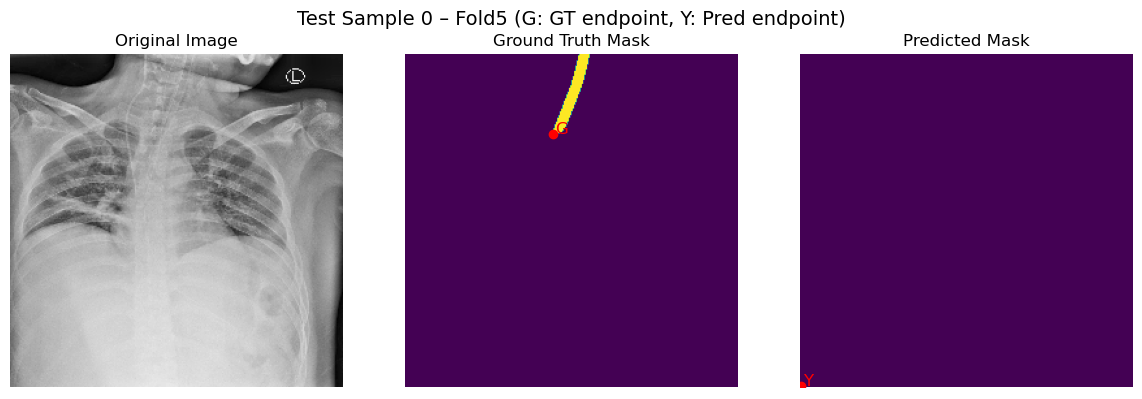

In [22]:
visualize_with_endpoints(0, test_x_rgb, test_y, model, fold_num="5")
